In [ ]:
---
title: Lab 7 (Heart Attack)
author: Ryan Neely
format:
    html:
        toc: true
        code-fold: false
        embed-resources: true
        echo: true
---


# Lab 7: Heart Attack
Instructions

You will submit an HTML document to Canvas as your final version.

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.
The Data

In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise. The information collected includes:

age : Age of the patient

sex : Sex of the patient

cp : Chest Pain type
Value 0: asymptomatic
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain

trtbps : resting blood pressure (in mm Hg)

chol : cholesterol in mg/dl fetched via BMI sensor

restecg : resting electrocardiographic results
Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria

thalach : maximum heart rate achieved during exercise

output : the doctor’s diagnosis of whether the patient is at risk for a heart attack
0 = not at risk of heart attack
1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_classic, ggtitle, scale_color_manual

In [3]:
ha_df = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha_df.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [7]:
X = ha_df.drop(columns=['output'])
y = ha_df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2 ,random_state=2)

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

## Part One: Fitting Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

Q1: KNN

Q2: Logistic Regression

Q3: Decision Tree

Q4: Interpretation Which predictors were most important to predicting heart attack risk?

Q5: ROC Curve Plot the ROC Curve for your three models above

In [6]:
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('knn', KNeighborsClassifier())
])

knn_params = {'knn__n_neighbors': range(1, 21)}
knn_gscv = GridSearchCV(KNN_pipeline, knn_params, cv=5, scoring='roc_auc')
knn_gscv.fit(X_train, y_train)

print(f"Best KNN parameters: {knn_gscv.best_params_}")
print(f"AUC: {knn_gscv.best_score_.round(5)}")

y_pred_knn = knn_gscv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred_knn))

Best KNN parameters: {'knn__n_neighbors': 17}
AUC: 0.84721
[[14  7]
 [ 7 27]]


In [5]:
logit_pipeline = Pipeline([
    ('preprocessor', ct),
    ('logit', LogisticRegression())
])

logit_params = {'logit__C': [0.01, 0.1, 1, 10, 100]}
logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='roc_auc')
logit_gscv.fit(X_train, y_train)

print(f"Best Logitistic parameters: {logit_gscv.best_params_}")
print(f"AUC: {logit_gscv.best_score_.round(5)}")

y_pred_logit = logit_gscv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred_logit))

Best Logitistic parameters: {'logit__C': 0.01}
AUC: 0.85397
[[16  5]
 [ 6 28]]


In [9]:
tree_pipeline = Pipeline([
    ('preprocessor', ct),
    ('tree', DecisionTreeClassifier(random_state=10))
])

tree_params = {'tree__max_depth': range(1, 20), 'tree__min_samples_split': range(2, 10)}
tree_gscv = GridSearchCV(tree_pipeline, tree_params, cv=5, scoring='roc_auc')
tree_gscv.fit(X_train, y_train)

print(f"Best Tree parameters: {tree_gscv.best_params_}")
print(f"AUC: {tree_gscv.best_score_.round(5)}")

y_pred_tree = tree_gscv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred_tree))

Best Tree parameters: {'tree__max_depth': 2, 'tree__min_samples_split': 2}
AUC: 0.80838
[[15  6]
 [ 7 27]]


### Interpretation

In [43]:
logit_coefs = logit_gscv.best_estimator_.named_steps['logit'].coef_
features = X.columns
print("Logistic Coefficients:")
for feature, coef in zip(features, logit_coefs[0]):
    print(f"{feature}: {coef}")

Logistic Coefficients:
age: -0.10003412393098401
sex: -0.2194021717506278
cp: 0.25875302572299697
trtbps: -0.09058342895414832
chol: -0.04861072310256404
restecg: 0.07975005070639171
thalach: 0.263116667106208


In [44]:
tree_model = tree_gscv.best_estimator_.named_steps['tree']

tree_imp = tree_model.feature_importances_

print("Decision Tree Coefficients:")
for feature, important in zip(features, tree_imp):
    print(f"{feature}: {important}")

Decision Tree Coefficients:
age: 0.11402003166996835
sex: 0.0
cp: 0.7320101623982976
trtbps: 0.0
chol: 0.0
restecg: 0.0
thalach: 0.15396980593173412


Above we can see the coefficients for the logistic regression and the decision tree model. From these coefficients we can see a few variables that are significant in both models. The most significant in both of these models is the cp variable which indicates the type of chest pain that a patient has. We can also see that age and thalatch are both important variables in each model. The logistic model places an impact on a wider variety of variables, such as sex and cholestoral. We can see that there are no variables that have a negative effect on the diagnosis for the decision tree while the logistic model has several variables that decrease the odds of being diagnosed with with a risk of heart attack.

### ROC Curves

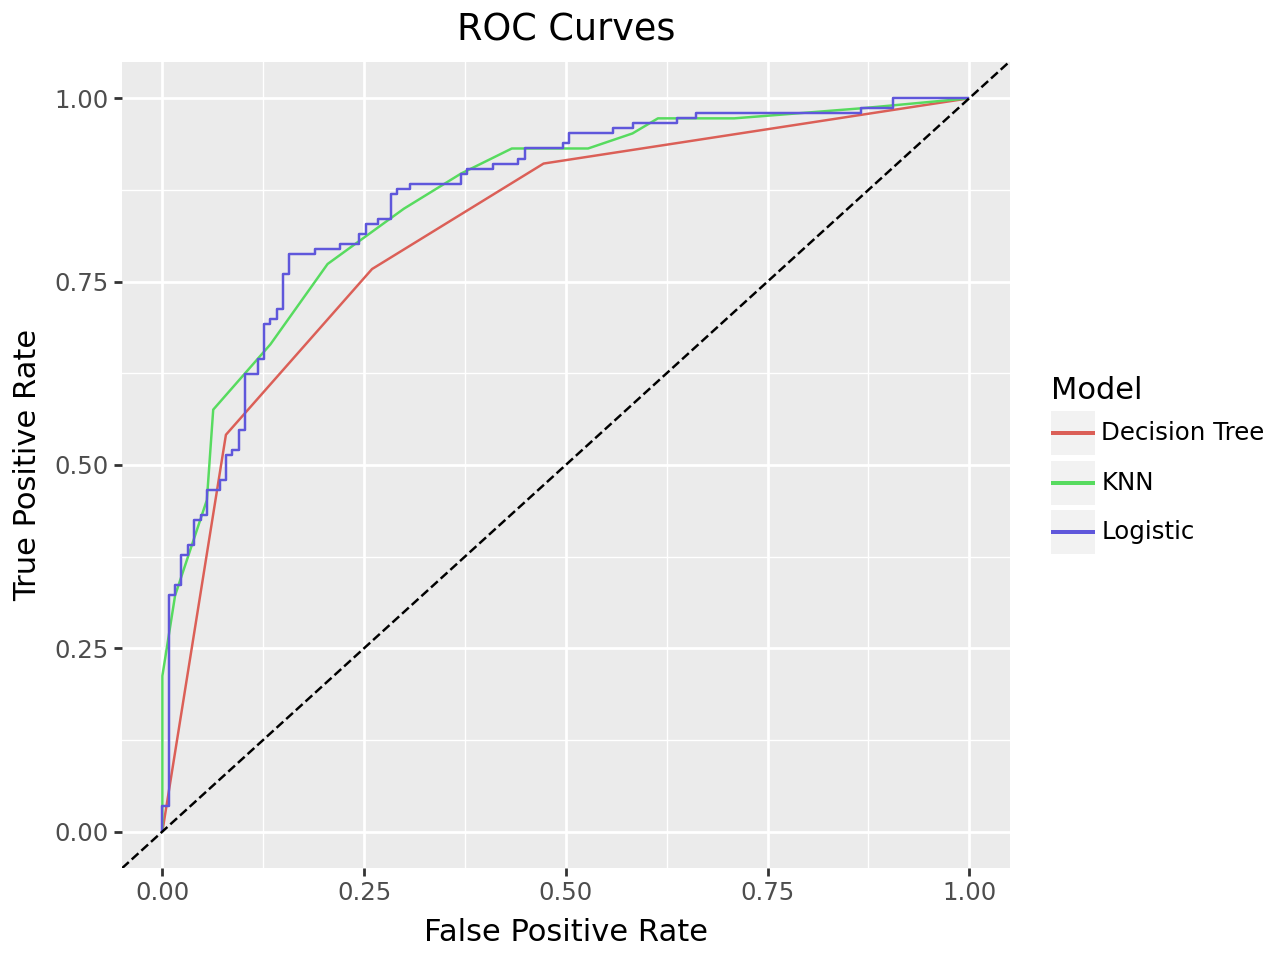

In [40]:
knn_prob = knn_gscv.best_estimator_.predict_proba(X)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y, knn_prob)
knn_auc = roc_auc_score(y, knn_prob)

logit_prob = logit_gscv.best_estimator_.predict_proba(X)[:, 1]
logit_fpr, logit_tpr, _ = roc_curve(y, logit_prob)
logit_auc = roc_auc_score(y, logit_prob)

tree_prob = tree_gscv.best_estimator_.predict_proba(X)[:, 1]
tree_fpr, tree_tpr, _ = roc_curve(y, tree_prob)
tree_auc = roc_auc_score(y, tree_prob)


curve_df = pd.DataFrame({
    'False Positive': list(knn_fpr) + list(logit_fpr) + list(tree_fpr),
    'True Positive': list(knn_tpr) + list(logit_tpr) + list(tree_tpr),
    'Model': (
        ['KNN'.format(knn_auc)] * len(knn_fpr) +
        ['Logistic'.format(logit_auc)] * len(logit_fpr) +
        ['Decision Tree'.format(tree_auc)] * len(tree_fpr)
    )
})

(ggplot(curve_df, pt.aes(x='False Positive', y='True Positive', color='Model')) +
geom_line() +
geom_abline(linetype='dashed', color='black') + 
labs(title='ROC Curves', x='False Positive Rate', y='True Positive Rate')
)

## Part 2: Metrics

In [22]:

knn_y_pred = cross_val_predict(KNN_pipeline, X, y, cv=5)
logit_y_pred = cross_val_predict(logit_pipeline, X, y, cv=5)
tree_y_pred = cross_val_predict(tree_pipeline, X, y, cv=5)

knn_recall = recall_score(y, knn_y_pred)
logit_recall = recall_score(y, logit_y_pred)
tree_recall = recall_score(y, tree_y_pred)

knn_precision = precision_score(y, knn_y_pred)
logit_precision = precision_score(y, logit_y_pred)
tree_precision = precision_score(y, tree_y_pred)

knn_conf = confusion_matrix(y, knn_y_pred)
logit_conf = confusion_matrix(y, logit_y_pred)
tree_conf = confusion_matrix(y, tree_y_pred)
knn_tn, knn_fp, _, _ = knn_conf.ravel()
logit_tn, logit_fp, _, _ = logit_conf.ravel()
tree_tn, tree_fp, _, _ = tree_conf.ravel()

knn_spec = knn_tn / (knn_tn + knn_fp)
logit_spec = logit_tn / (logit_tn + logit_fp)
tree_spec = tree_tn / (tree_tn + tree_fp)


print('KNN Recall:', {knn_recall.round(4)})
print('Logistic Recall:', {logit_recall.round(4)})
print('Decision Tree Recall:', {tree_recall.round(4)})
print('')
print('KNN Precision:', {knn_precision.round(4)})
print('Logistic Precision:', {logit_precision.round(4)})
print('Decision Tree Precision:', {tree_precision.round(4)})
print('')
print('KNN Specificity:', {knn_spec.round(4)})
print('Logistic Specificity:', {logit_spec.round(4)})
print('Decision Tree Specificity:', {tree_spec.round(4)})


KNN Recall: {0.7808}
Logistic Recall: {0.8219}
Decision Tree Recall: {0.6575}

KNN Precision: {0.717}
Logistic Precision: {0.7895}
Decision Tree Precision: {0.7164}

KNN Specificity: {0.6457}
Logistic Specificity: {0.748}
Decision Tree Specificity: {0.7008}


## Part 3: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.


### Q1

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

The metric that I would focus on for this situation is recall. This metric looks at the rate of correctly predicited positive cases. This would be the metric to focus on because in this situation we are looking to correctly identify the patients that are at a high risk of a heart attack. The model with the best recall rate is the logistic model which has a recall rate of 0.82. Using this model we would expect a recall rate of 0.82, precision of 0.79, and specificity of 0.75.


### Q2

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

In this example I would focus mostly on the precision rate of the model. The precision of the model is the rate the true positives which is important here since we are looking to have the model that identifies the patients at risk of a heart attack the most. The model with the highest precision is the logistic model with a rate of 0.79. Using this model we expect to see a precision of 0.79, recall rate of 0.82, and specificity of 0.75.


### Q3

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

In this case I would use the logistic model because the results of the model of interpretable. The logistic model has coefficients that can be interpreted as being more or less associated with heart attack risks. By using the logisitc model we can expect an AUC of 0.85, recall of 0.82, precision of 0.79, and specificity of 0.75. 


### Q4

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

The type of model that I would choose in this situation is the decision tree. In this example decisions trees mimic the decision making that may be done when predicting if a patient will have a certain type of diagnosis. By using the decision tree model we can compare diagnoses in a way that is easy to interpret and visualize. By using the decision tree model we expect to see a AUC of 0.8, recall of 0.66, precision of 0.72, and specificity of 0.70.

## Part 4: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [23]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")


In [24]:
X_val = ha_validation.drop(columns=['output'])
y_val = ha_validation['output']

In [33]:
knn_pred = knn_gscv.best_estimator_.predict(X_val)
knn_prob = knn_gscv.best_estimator_.predict_proba(X_val)[:, 1]


knn_val_conf = confusion_matrix(y_val, knn_pred)
print(knn_val_conf)

knn_recall_val = recall_score(y_val, knn_pred)
print('KNN Recall:', knn_recall_val.round(4))

knn_precision = precision_score(y_val, knn_pred)
print('KNN Precision:', knn_precision.round(4))

knn_auc_val = roc_auc_score(y_val, knn_prob)
print('AUC KNN:', knn_auc_val.round(4))
print('')

logit_pred = logit_gscv.best_estimator_.predict(X_val)
logit_prob = logit_gscv.best_estimator_.predict_proba(X_val)[:, 1]

logit_val_conf = confusion_matrix(y_val, logit_pred)
print(logit_val_conf)

logit_recall_val = recall_score(y_val, logit_pred)
print('Logistic Recall:', logit_recall_val.round(4))

logit_precision = precision_score(y_val, logit_pred)
print('Logistic Precision:', logit_precision.round(4))

logit_auc_val = roc_auc_score(y_val, logit_prob)
print('AUC Logistic:', logit_auc_val.round(4))
print('')


tree_pred = tree_gscv.best_estimator_.predict(X_val)
tree_prob = tree_gscv.best_estimator_.predict_proba(X_val)[:, 1]

tree_val_conf = confusion_matrix(y_val, tree_pred)
print(tree_val_conf)

tree_recall_val = recall_score(y_val, tree_pred)
print('Decision Tree Recall:', tree_recall_val.round(4))

tree_precision = precision_score(y_val, tree_pred)
print('Decision Tree Precision:', tree_precision.round(4))

tree_auc_val = roc_auc_score(y_val, tree_prob)
print('AUC Decision Tree:', tree_auc_val.round(4))

[[11  0]
 [ 6 13]]
KNN Recall: 0.6842
KNN Precision: 1.0
AUC KNN: 0.9354

[[10  1]
 [ 4 15]]
Logistic Recall: 0.7895
Logistic Precision: 0.9375
AUC Logistic: 0.9234

[[10  1]
 [ 5 14]]
Decision Tree Recall: 0.7368
Decision Tree Precision: 0.9333
AUC Decision Tree: 0.9043


For the KNN model, the recall rate is lower than what we expected to see based on the cross validation metric. However, The precision and the AUC is much higher than expected. 

For the logistic regression model, the recall rate is slightly lower than what we expected, but the precision and AUC are also both higher than the cross validation metrics.

For the decision tree, the recall rate, precision, and the ROC AUC are all higher than the cross validation metrics.

From the new metrics we can still see that logistic is the best model in terms of recall rate. Each of the three models are relatively close together for the precision. Lastly, the ROC AUC is the highest for the KNN model which is different from the cross validation metric which had logistic being the highest.

## Part 5: Cohen’s Kappa

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [38]:
from sklearn.metrics import cohen_kappa_score

def kappa(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, y_pred)
    print(f"{model_name} Cohen's Kappa: {kappa:.4f}")
    return kappa

# Calculate Kappa for each model
knn_kappa = kappa(knn_gscv.best_estimator_, X_val, y_val, "KNN")
logreg_kappa = kappa(logit_gscv.best_estimator_, X_val, y_val, "Logistic")
tree_kappa = kappa(tree_gscv.best_estimator_, X_val, y_val, "Decision Tree")

KNN Cohen's Kappa: 0.6137
Logistic Cohen's Kappa: 0.6606
Decision Tree Cohen's Kappa: 0.6000


The highest value for Cohen's Kappa out of these three models is 0.66 for the Logistic regression model. Cohen's Kappa is a metric that quantifies accuracy of the model while accounting for the probability that some correct matches may occur due to random chance. This seems like a good metric in examples like doctor diagnoses. By using this metric, the logisitic model is the best model for predictability which is in line with our previous results. Overall, I think that Cohen's Kappa should be a metric that we use to test for predictability in this example, but it should also be paired with other metrics like precision, sensitivity, specificity, and AUC. There will be specific instances in which a certain metric will be more important to optimze than others. In order to have a balance between precision and sensitivity, Cohen's Kappa is a useful metric as it accounts for chance, but quantifies accuracy.

Chat GPT was used to help with trouble shooting when I ran into a few different syntax errors. It also assisted with formatting the model coefficients and the data frame to make the ROC curves plot. Other than that it was only used to assist with correcting errors.